# **🎨 프로젝트: AI 생성 그림 판별**
- **0. 개요**  
- **1. 데이터 준비**  
- **2. 모델링**
- **3. 결론**  

# 0. 개요
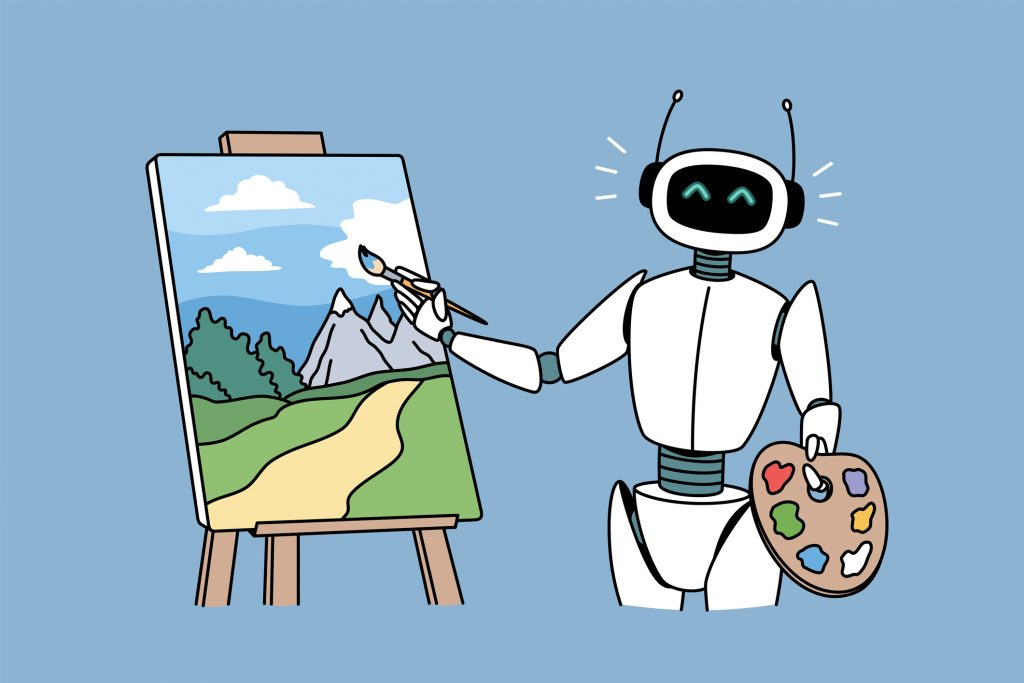

## 소개 및 목적

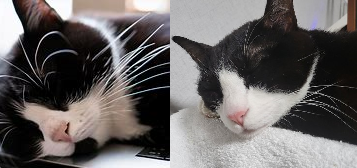

`본 프로젝트는 AI 생성 그림과 사람이 그린 그림을 구분할 수 있는 딥러닝 모델을 개발하고자 합니다.`  
`최근 AI 기술의 발전으로 인해 생성적 적대 신경망(GAN)과 같은 기술을 사용하여 매우 현실적인 이미지를 생성할 수 있게 되었고, 이로 인해 AI가 생성한 이미지와 사람이 그린 이미지를 구분하는 것이 어려워졌습니다.`  
`따라서 이 프로젝트는 AI 생성 이미지와 사람이 그린 이미지를 분류하는 딥러닝 모델을 개발하여 AI 기술의 발전에 따른 영향을 평가하고자 합니다.`

## 데이터 설명

1. kaggle 데이터 셋  
[Detecting AI-generated artwork](https://www.kaggle.com/datasets/birdy654/detecting-ai-generated-artwork)  
AI가 생성한 FAKE 그림 1705장, 사람이 그린 REAL 그림 1705장

2. 뤼튼 AI 플랫폼 그림 생성  
[;wrtn](https://wrtn.ai/)  
FAKE 그림 152장

3. 본인 그림  
REAL 그림 152장

## 가설 설정

AI가 생성한 그림과 사람이 그린 그림은 딥러닝 모델을 통해 구분할 수 있을 것이다.

## 딥러닝 파이프라인 구축

1. AI 생성 그림과 사람이 그린 그림의 데이터셋을 수집하고 전처리하여 학습에 사용할 수 있는 형태로 만듭니다.
2. 이미지 분류에 적합한 딥러닝 모델(예: CNN)을 구축하고, 필요한 경우 사전 학습된 모델을 활용하여 전이 학습을 진행합니다.
3. 학습, 검증, 테스트 데이터셋을 사용하여 모델의 성능을 평가하고, 하이퍼파라미터 튜닝을 통해 모델 성능을 최적화합니다.
4. 최종적으로 개발된 모델을 사용하여 AI 생성 그림과 사람이 그린 그림을 분류하는 성능을 평가하고, 가설을 검증합니다.
5. 결과 분석을 통해 모델의 성능을 개선할 수 있는 방향을 탐구하고, AI 기술의 발전에 따른 영향을 이해합니다.

# 1. 데이터 준비

In [ ]:
# 필요한 패키지와 라이브러리 불러오기
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers, initializers, regularizers, metrics

In [ ]:
# 시드 고정
np.random.seed(42)
tf.random.set_seed(42)

## 데이터 가져오기

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 이미지 생성 옵션 설정
train_datagen = ImageDataGenerator(rescale=1./255,        # 정규화
                                  horizontal_flip=True,   # 수평 대칭
                                  width_shift_range=0.1,  # 10% 범위에서 좌우로 이동
                                  height_shift_range=0.1, # 위, 아래로 이동
                                  #rotation_range=5,       # 회전
                                  #shear_range=0.7,        # 좌표 하나 고정, 나머지 좌표 이동
                                  #zoom_range=[0.9, 2.2],  # 정해진 범위 내 축소, 확대
                                  #vertical_flip=True,     # 수직 대칭
                                  fill_mode='nearest')    # 빈 공간 가까운 색으로 채움

# 검증 데이터는 정규화 과정만 진행
validation_datagen = ImageDataGenerator(rescale=1./255)  

In [ ]:
# 이미지 불러오기
train_dir = '/content/drive/MyDrive/train'
validation_dir = '/content/drive/MyDrive/validation'

train_generator = train_datagen.flow_from_directory(
       train_dir,
       target_size=(150, 150),
       batch_size=5,
       class_mode='binary') # fake / real 이진분류

validation_generator = validation_datagen.flow_from_directory(
       validation_dir,
       target_size=(150, 150),
       batch_size=5,
       class_mode='binary')

Found 2410 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


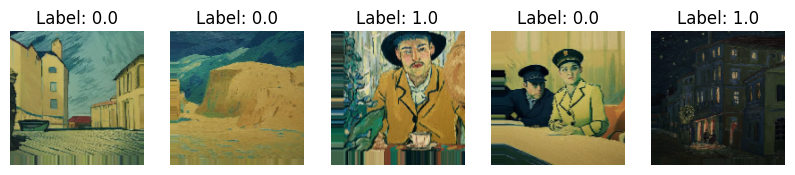

In [ ]:
# 샘플 이미지 가져오기
sample_images, sample_labels = next(train_generator)

# 이미지와 레이블 표시
plt.figure(figsize=(10, 10))
for i in range(5):  # 5개의 샘플 이미지를 표시
    plt.subplot(1, 5, i + 1)
    plt.imshow(sample_images[i])
    plt.title(f"Label: {sample_labels[i]}")
    plt.axis("off")
plt.show()

Label 0: 가짜(fake) 그림  
Label 1: 진짜(real) 그림

# 2. 모델링

## CNN 모델 직접 구축

In [ ]:
# CNN 모델 구성
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(150,150,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(2))
model.add(Activation('softmax'))

In [ ]:
# 모델 컴파일
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=0.0002), metrics=['accuracy'])

In [ ]:
# 모델 학습
history = model.fit_generator(
       train_generator,
       steps_per_epoch=100,
       epochs=20,
       validation_data=validation_generator,
       validation_steps=10)

<ipython-input-8-e5c4502daeb3>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/20
100/100 [==============================] - 258s 2s/step - loss: 0.6483 - accuracy: 0.6220 - val_loss: 0.5086 - val_accuracy: 0.7400
Epoch 2/20
100/100 [==============================] - 182s 2s/step - loss: 0.4908 - accuracy: 0.7800 - val_loss: 0.4110 - val_accuracy: 0.8200
Epoch 3/20
100/100 [==============================] - 151s 2s/step - loss: 0.4301 - accuracy: 0.8200 - val_loss: 0.3131 - val_accuracy: 0.9000
Epoch 4/20
100/100 [==============================] - 127s 1s/step - loss: 0.3388 - accuracy: 0.8680 - val_loss: 0.5567 - val_accuracy: 0.7200
Epoch 5/20
100/100 [==============================] - 105s 1s/step - loss: 0.3279 - accuracy: 0.8580 - val_loss: 0.3051 - val_accuracy: 0.8600
Epoch 6/20
100/100 [==============================] - 102s 1s/step - loss: 0.2975 - accuracy: 0.8880 - val_loss: 0.4908 - val_accuracy: 0.8200
Epoch 7/20
100/100 [==============================] - 89s 892ms/step - loss: 0.2961 - accuracy: 0.8860 - val_loss: 0.1987 - val_accuracy: 0.94

20번의 epoch만에 검증셋 정확도 0.9, 예측 loss 0.3564 달성

In [ ]:
# 결과를 그래프로 나타내기
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

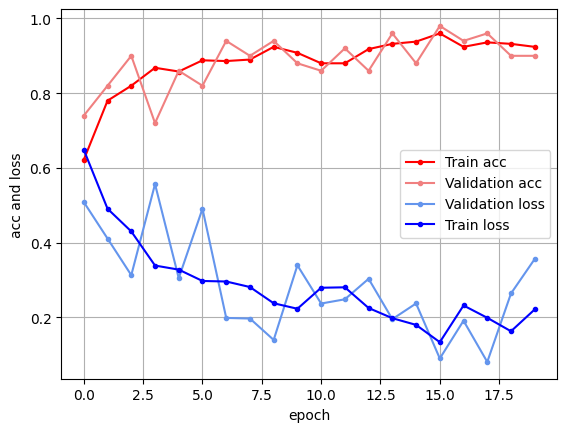

In [ ]:
x_len = np.arange(len(y_loss))  
plt.plot(x_len, acc, marker='.', c="red", label='Train acc')
plt.plot(x_len, val_acc, marker='.', c="lightcoral", label='Validation acc')
plt.plot(x_len, y_vloss, marker='.', c="cornflowerblue", label='Validation loss')
plt.plot(x_len, y_loss, marker='.', c="blue", label='Train loss')

plt.legend(loc='center right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('acc and loss')
plt.show()

## 전이 학습으로 모델 성능 극대화

In [ ]:
# 미리 학습된 모델 VGGNet 사용
from tensorflow.keras import Input, models, layers, optimizers, metrics
from tensorflow.keras.applications import VGG16

In [ ]:
# 시드 고정
np.random.seed(42)
tf.compat.v1.set_random_seed(42)

In [ ]:
# VGG16 모델 불러오기
transfer_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
transfer_model.trainable = False  # 새로 학습 되지 않도록
transfer_model.summary()

58889256/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                              

학습 가능한 파라미터 없음 확인

In [ ]:
# 로컬 네트워크 만들기
finetune_model = models.Sequential()
finetune_model.add(transfer_model)
finetune_model.add(Flatten())
finetune_model.add(Dense(64, activation='relu'))
finetune_model.add(Dense(2, activation='softmax'))
finetune_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 64)                524352    
                                                                 
 dense_3 (Dense)             (None, 2)                 130       
                                                                 
Total params: 15,239,170
Trainable params: 524,482
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
# 모델 컴파일
finetune_model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=0.0002), metrics=['accuracy'])

In [ ]:
# 모델 학습
history = finetune_model.fit_generator(
       train_generator,
       steps_per_epoch=100,
       epochs=20,
       validation_data=validation_generator,
       validation_steps=4)

Epoch 1/20


<ipython-input-18-3996618a157b>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = finetune_model.fit_generator(


100/100 [==============================] - 21s 186ms/step - loss: 0.3165 - accuracy: 0.8740 - val_loss: 0.2007 - val_accuracy: 0.9000
Epoch 2/20
100/100 [==============================] - 16s 164ms/step - loss: 0.1767 - accuracy: 0.9380 - val_loss: 0.0850 - val_accuracy: 0.9500
Epoch 3/20
100/100 [==============================] - 17s 166ms/step - loss: 0.1171 - accuracy: 0.9620 - val_loss: 0.0627 - val_accuracy: 1.0000
Epoch 4/20
100/100 [==============================] - 10s 102ms/step - loss: 0.0973 - accuracy: 0.9740 - val_loss: 0.0146 - val_accuracy: 1.0000
Epoch 5/20
100/100 [==============================] - 13s 127ms/step - loss: 0.1393 - accuracy: 0.9540 - val_loss: 0.2437 - val_accuracy: 0.9000
Epoch 6/20
100/100 [==============================] - 14s 145ms/step - loss: 0.0872 - accuracy: 0.9740 - val_loss: 0.0272 - val_accuracy: 1.0000
Epoch 7/20
100/100 [==============================] - 12s 124ms/step - loss: 0.0772 - accuracy: 0.9760 - val_loss: 0.0192 - val_accuracy: 1.0

0.9 였던 검증 정확도가 전이 학습이후 0.95로 상승  
예측 오차도 0.3564에서 0.1061로 낮아짐  
30분 걸리던 학습 시간도 5분으로 단축

In [ ]:
# 결과를 그래프로 나타내기
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

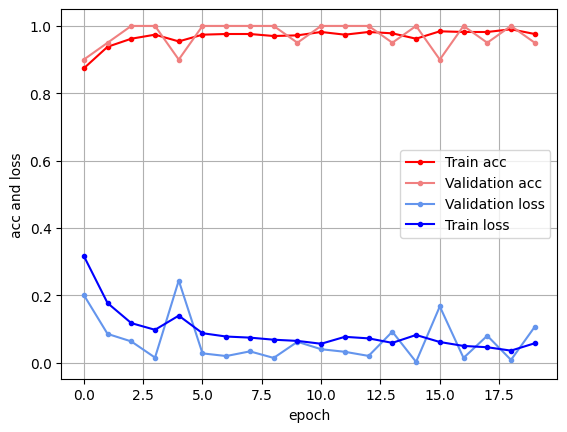

In [ ]:
x_len = np.arange(len(y_loss))  
plt.plot(x_len, acc, marker='.', c="red", label='Train acc')
plt.plot(x_len, val_acc, marker='.', c="lightcoral", label='Validation acc')
plt.plot(x_len, y_vloss, marker='.', c="cornflowerblue", label='Validation loss')
plt.plot(x_len, y_loss, marker='.', c="blue", label='Train loss')

plt.legend(loc='center right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('acc and loss')
plt.show()

## 새로운 데이터로 테스트

In [ ]:
#정규화 과정만 진행
test_datagen = ImageDataGenerator(rescale=1./255)  

In [ ]:
# 이미지 불러오기
test_dir = '/content/drive/MyDrive/test'

test_generator = test_datagen.flow_from_directory(
       test_dir,
       target_size=(150, 150),
       batch_size=5,
       class_mode='binary')

Found 304 images belonging to 2 classes.


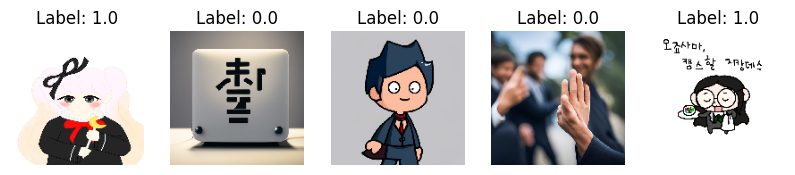

In [ ]:
# 샘플 이미지 가져오기
sample_images, sample_labels = next(test_generator)

# 이미지와 레이블 표시
plt.figure(figsize=(10, 10))
for i in range(5):  # 5개의 샘플 이미지를 표시
    plt.subplot(1, 5, i + 1)
    plt.imshow(sample_images[i])
    plt.title(f"Label: {sample_labels[i]}")
    plt.axis("off")
plt.show()

In [ ]:
# 테스트 데이터셋에 대한 성능 평가
test_loss, test_accuracy = finetune_model.evaluate(test_generator)

61/61 [==============================] - 105s 2s/step - loss: 3.7629 - accuracy: 0.5263


## 다시 새로 학습 후 평가

In [ ]:
# 시드 고정
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
# 이미지 생성 옵션 설정
train_datagen2 = ImageDataGenerator(rescale=1./255,
                                  horizontal_flip=True,   # 수평 대칭 이미지를 50% 확률로 만들어 추가합니다.
                                  width_shift_range=0.1,  # 전체 크기의 10% 범위에서 좌우로 이동합니다.
                                  height_shift_range=0.1, # 마찬가지로 위, 아래로 이동합니다.
                                  #rotation_range=5,
                                  #shear_range=0.7,
                                  #zoom_range=[0.9, 2.2],
                                  #vertical_flip=True,
                                  fill_mode='nearest',
                                  validation_split=0.25)  # 검증 데이터 분리

In [ ]:
# 이미지 불러오기
train_dir2 = '/content/drive/MyDrive/train2'

train_generator2 = train_datagen2.flow_from_directory(
       train_dir2,
       target_size=(150, 150),
       batch_size=5,
       class_mode='binary') # fake / real 이진분류

validation_generator2 = train_datagen2.flow_from_directory(
       train_dir2,
       target_size=(150, 150),
       batch_size=5,
       class_mode='binary', # fake / real 이진분류
       subset='validation') # 'validation'으로 설정

Found 114 images belonging to 2 classes.
Found 28 images belonging to 2 classes.


In [ ]:
# 로컬 네트워크 만들기
finetune_model2 = models.Sequential()
finetune_model2.add(transfer_model)
finetune_model2.add(Flatten())
finetune_model2.add(Dense(64, activation='relu'))
finetune_model2.add(Dense(2, activation='softmax'))
finetune_model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 64)                524352    
                                                                 
 dense_3 (Dense)             (None, 2)                 130       
                                                                 
Total params: 15,239,170
Trainable params: 524,482
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
# 모델 컴파일
finetune_model2.compile(loss='sparse_categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=0.0002), metrics=['accuracy'])

In [ ]:
# 모델 학습
history2 = finetune_model2.fit_generator(
       train_generator2,
       steps_per_epoch=5,
       epochs=1,
       validation_data=validation_generator2,
       validation_steps=4)

<ipython-input-13-a91d195c7f5f>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history2 = finetune_model2.fit_generator(


5/5 [==============================] - 3s 380ms/step - loss: 0.1773 - accuracy: 0.9200 - val_loss: 0.0034 - val_accuracy: 1.0000


한 번의 epoch 만으로 val_accuracy 1 달성

In [ ]:
# 검증 데이터는 정규화 과정만 진행
test_datagen2 = ImageDataGenerator(rescale=1./255)  

In [ ]:
test_dir2 = '/content/drive/MyDrive/test2'

test_generator2 = test_datagen2.flow_from_directory(
       test_dir2,
       target_size=(150, 150),
       batch_size=5,
       class_mode='binary')

Found 38 images belonging to 2 classes.


In [ ]:
# 테스트 데이터셋에 대한 성능 평가
test_loss, test_accuracy = finetune_model2.evaluate(test_generator2)

8/8 [==============================] - 9s 1s/step - loss: 0.0036 - accuracy: 1.0000


# 3. 결론

## 활용 방안 및 기대 효과

활용 방안 및 기대 효과:
1. 딥러닝 모델을 활용하여 AI 생성 그림과 사람이 그린 그림을 구분하는 능력을 개선할 수 있습니다. 이를 통해 온라인에서 공유되는 이미지의 출처와 진위를 판별하는데 도움이 될 것입니다.
2. 개발된 모델은 디지털 미디어 및 광고 산업에서 사용되는 이미지의 출처를 확인하는데 활용할 수 있습니다. 이를 통해 저작권 침해나 부적절한 이미지 사용을 줄일 수 있습니다.
3. 예술 및 디자인 분야에서 AI 생성 이미지와 인간의 창작물 간의 차이를 이해하고, 두 가지 유형의 작품을 결합하여 새로운 창작물을 만드는데 활용할 수 있습니다.

## 한계점 및 향후 계획

한계점:  
데이터셋의 편향으로 인해 일부 특정 스타일의 이미지를 구분하는 데에 어려움이 있었습니다. 이를 해결하기 위해서는 다양한 스타일의 이미지를 포함하는 풍부한 데이터셋을 수집해야 합니다.

향후 계획:  
모델 성능을 개선하기 위해 추가적인 데이터셋을 수집하고, 최신 AI 이미지 생성 기술을 계속 모니터링하여 새로운 기술이 도입된 이미지를 구분할 수 있는 능력을 모델에 반영할 수 있도록 합니다.